# FMLIKH Model: Large Amplitude Oscillatory Shear (LAOS)

## Learning Objectives

1. Fit FMLIKH to **LAOS** experimental data
2. Analyze **multi-mode Lissajous curves** and harmonic content
3. Compare FMLIKH vs single-mode FIKH nonlinear response
4. Understand harmonic enrichment from multiple relaxation modes

## Prerequisites

- NB07: FMLIKH Flow Curve
- NB06: FIKH LAOS (single-mode concepts)

## Runtime Configuration

This notebook supports two modes:
- **FAST_MODE=True** (default): ~15-20 minutes, reduced samples for quick validation
- **FAST_MODE=False**: Full Bayesian run, may take 1+ hours on CPU

## 1. Setup

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import os, sys, time, warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_pnas_laos, save_fikh_results, print_convergence_summary,
    compute_fit_quality, get_fmlikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)

# ============================================================
# FAST_MODE Configuration
# ============================================================
# Set to False for full Bayesian run (1+ hours on CPU)
# Set to True for quick validation (~15-20 minutes)
FAST_MODE = True

if FAST_MODE:
    print("Running in FAST_MODE - reduced samples for quick validation")
    DOWNSAMPLE_FACTOR = 4  # Use every 4th data point
    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 100, 200, 1
else:
    print("Running in FULL mode - complete Bayesian inference")
    DOWNSAMPLE_FACTOR = 1  # Use all data
    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

Running in FAST_MODE - reduced samples for quick validation


## 2. Load Data

In [3]:
OMEGA = 1.0
STRAIN_AMP_INDEX = 5

time_raw, strain_raw, stress_raw = load_pnas_laos(omega=OMEGA, strain_amplitude_index=STRAIN_AMP_INDEX)

# Apply downsampling for FAST_MODE
if DOWNSAMPLE_FACTOR > 1:
    time_data = time_raw[::DOWNSAMPLE_FACTOR]
    strain_data = strain_raw[::DOWNSAMPLE_FACTOR]
    stress_data = stress_raw[::DOWNSAMPLE_FACTOR]
    print(f"Downsampled {len(time_raw)} -> {len(time_data)} points (factor {DOWNSAMPLE_FACTOR}x)")
else:
    time_data, strain_data, stress_data = time_raw, strain_raw, stress_raw

gamma_0 = (np.max(strain_data) - np.min(strain_data)) / 2

print(f"Data points: {len(time_data)}")
print(f"Strain amplitude: {gamma_0:.4f}")

Downsampled 1000 -> 250 points (factor 4x)
Data points: 250
Strain amplitude: 0.5120


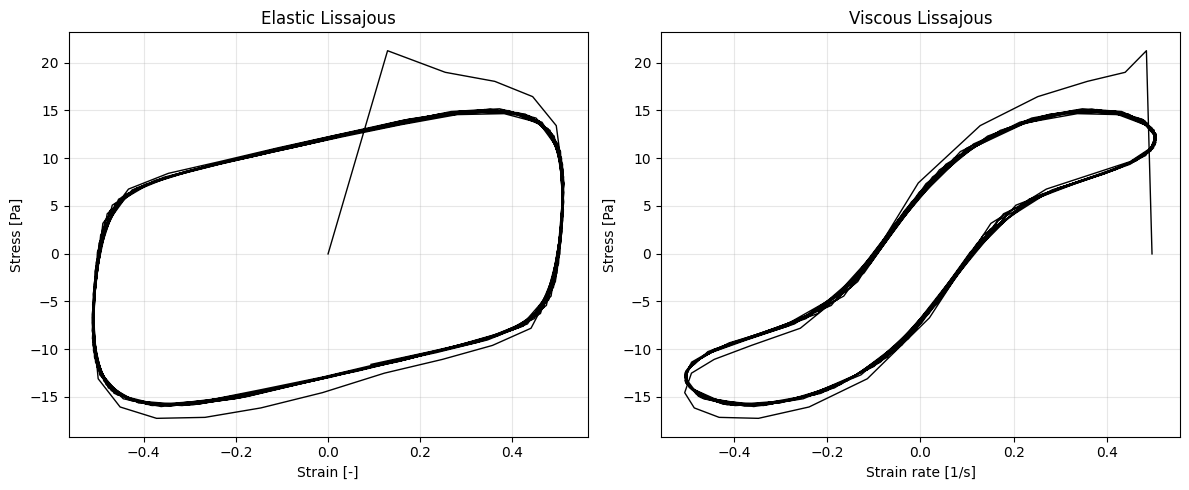

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(strain_data, stress_data, "k-", lw=1)
ax1.set_xlabel("Strain [-]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Elastic Lissajous")
ax1.grid(True, alpha=0.3)

gamma_dot_data = np.gradient(strain_data, time_data)
ax2.plot(gamma_dot_data, stress_data, "k-", lw=1)
ax2.set_xlabel("Strain rate [1/s]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Viscous Lissajous")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 3. NLSQ Fitting

In [5]:
# Number of modes: reduced in FAST_MODE for speed
N_MODES = 2 if FAST_MODE else 3
print(f"Using {N_MODES} modes (FAST_MODE={FAST_MODE})")

model = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.7)

t0 = time.time()
model.fit(time_data, stress_data, test_mode="laos", strain=strain_data, method='scipy')
print(f"NLSQ time: {time.time() - t0:.2f} s")

# Predict
laos_result = model.predict(time_data, test_mode="laos", strain=strain_data)
stress_pred = np.asarray(laos_result)
metrics = compute_fit_quality(stress_data, stress_pred)
print(f"R² = {metrics['R2']:.6f}")

Using 2 modes (FAST_MODE=True)


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fmlikh.py", line 532, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ time: 1.05 s
R² = -7.833702


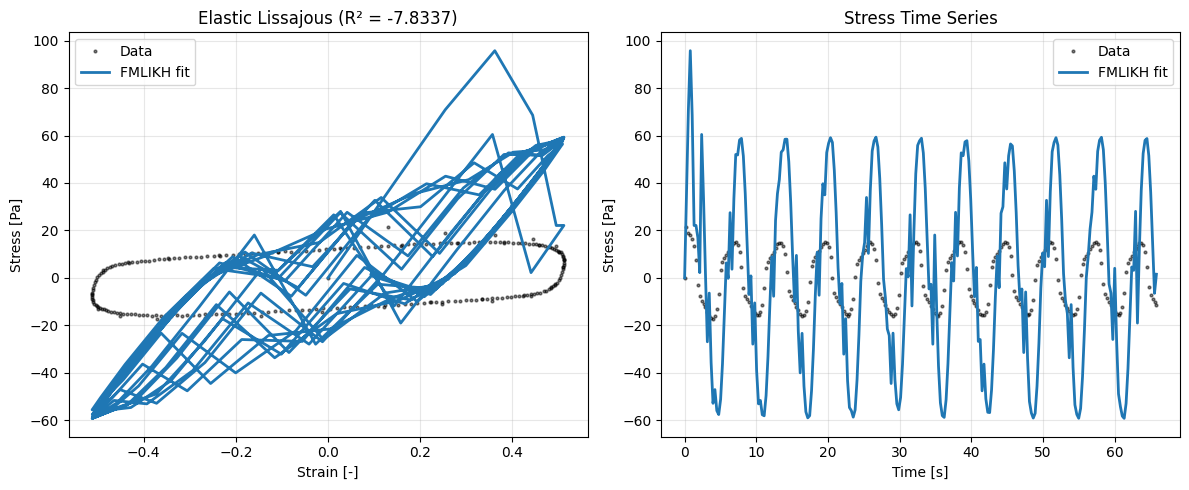

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(strain_data, stress_data, "ko", markersize=2, alpha=0.5, label="Data")
ax1.plot(strain_data, stress_pred, "-", lw=2, color="C0", label="FMLIKH fit")
ax1.set_xlabel("Strain [-]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title(f"Elastic Lissajous (R² = {metrics['R2']:.4f})")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(time_data, stress_data, "ko", markersize=2, alpha=0.5, label="Data")
ax2.plot(time_data, stress_pred, "-", lw=2, color="C0", label="FMLIKH fit")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Stress Time Series")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Bayesian Inference

In [7]:
param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)
initial_values = {n: model.parameters.get_value(n) for n in param_names if n in model.parameters}

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print(f"  FAST_MODE={FAST_MODE}, N_MODES={N_MODES}, data points={len(time_data)}")

t0 = time.time()
result = model.fit_bayesian(
    time_data, stress_data, test_mode="laos", strain=strain_data,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"Bayesian time: {t_bayes:.1f} s")

Running NUTS: 100 warmup + 200 samples x 1 chain(s)
  FAST_MODE=True, N_MODES=2, data points=250


  0%|          | 0/300 [00:00<?, ?it/s]

warmup:   0%|          | 1/300 [00:00<04:02,  1.23it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 9/300 [00:03<01:42,  2.84it/s, 1023 steps of size 1.40e-10. acc. prob=0.11]

warmup:   3%|▎         | 10/300 [00:05<03:08,  1.54it/s, 1023 steps of size 1.40e-10. acc. prob=0.20]

warmup:   4%|▎         | 11/300 [00:08<04:31,  1.06it/s, 1023 steps of size 1.48e-10. acc. prob=0.27]

warmup:   4%|▍         | 12/300 [00:10<06:06,  1.27s/it, 1023 steps of size 1.64e-10. acc. prob=0.33]

warmup:   4%|▍         | 13/300 [00:13<07:25,  1.55s/it, 1023 steps of size 1.89e-10. acc. prob=0.38]

warmup:   5%|▍         | 14/300 [00:15<08:24,  1.76s/it, 1023 steps of size 2.22e-10. acc. prob=0.43]

warmup:   5%|▌         | 15/300 [00:18<09:22,  1.97s/it, 1023 steps of size 2.67e-10. acc. prob=0.47]

warmup:   5%|▌         | 16/300 [00:20<09:59,  2.11s/it, 1023 steps of size 3.25e-10. acc. prob=0.50]

warmup:   6%|▌         | 17/300 [00:23<10:22,  2.20s/it, 1023 steps of size 4.01e-10. acc. prob=0.53]

warmup:   6%|▌         | 18/300 [00:25<10:40,  2.27s/it, 1023 steps of size 4.81e-10. acc. prob=0.55]

warmup:   6%|▋         | 19/300 [00:28<10:53,  2.32s/it, 1023 steps of size 5.91e-10. acc. prob=0.58]

warmup:   7%|▋         | 20/300 [00:30<11:08,  2.39s/it, 1023 steps of size 7.38e-10. acc. prob=0.60]

warmup:   7%|▋         | 21/300 [00:33<11:18,  2.43s/it, 1023 steps of size 9.22e-10. acc. prob=0.62]

warmup:   7%|▋         | 22/300 [00:35<10:34,  2.28s/it, 731 steps of size 7.35e-10. acc. prob=0.63] 

warmup:   8%|▊         | 23/300 [00:37<09:50,  2.13s/it, 723 steps of size 5.40e-10. acc. prob=0.64]

warmup:   8%|▊         | 24/300 [00:39<10:17,  2.24s/it, 1023 steps of size 1.94e-10. acc. prob=0.63]

warmup:   8%|▊         | 25/300 [00:42<10:35,  2.31s/it, 1023 steps of size 2.47e-10. acc. prob=0.65]

warmup:   9%|▊         | 26/300 [00:44<10:59,  2.41s/it, 1023 steps of size 2.48e-10. acc. prob=0.66]

warmup:   9%|▉         | 27/300 [00:47<11:02,  2.43s/it, 1023 steps of size 3.13e-10. acc. prob=0.67]

warmup:   9%|▉         | 28/300 [00:49<11:02,  2.44s/it, 1023 steps of size 4.80e-11. acc. prob=0.66]

warmup:  10%|▉         | 29/300 [00:52<11:11,  2.48s/it, 1023 steps of size 3.59e-11. acc. prob=0.66]

warmup:  10%|█         | 30/300 [00:54<11:06,  2.47s/it, 1023 steps of size 1.73e-11. acc. prob=0.66]

warmup:  10%|█         | 31/300 [00:57<11:08,  2.49s/it, 1023 steps of size 2.23e-11. acc. prob=0.67]

warmup:  11%|█         | 32/300 [00:59<11:10,  2.50s/it, 1023 steps of size 2.06e-11. acc. prob=0.68]

warmup:  11%|█         | 33/300 [01:02<11:06,  2.50s/it, 1023 steps of size 2.57e-11. acc. prob=0.69]

warmup:  11%|█▏        | 34/300 [01:04<11:05,  2.50s/it, 1023 steps of size 3.15e-11. acc. prob=0.70]

warmup:  12%|█▏        | 35/300 [01:07<11:03,  2.50s/it, 1023 steps of size 3.28e-11. acc. prob=0.70]

warmup:  12%|█▏        | 36/300 [01:09<11:01,  2.51s/it, 1023 steps of size 3.20e-11. acc. prob=0.71]

warmup:  12%|█▏        | 37/300 [01:12<11:15,  2.57s/it, 1023 steps of size 3.98e-11. acc. prob=0.72]

warmup:  13%|█▎        | 38/300 [01:14<11:15,  2.58s/it, 1023 steps of size 4.05e-11. acc. prob=0.72]

warmup:  13%|█▎        | 39/300 [01:17<11:06,  2.56s/it, 1023 steps of size 4.97e-11. acc. prob=0.73]

warmup:  13%|█▎        | 40/300 [01:20<11:01,  2.54s/it, 1023 steps of size 4.44e-11. acc. prob=0.73]

warmup:  14%|█▎        | 41/300 [01:22<10:54,  2.53s/it, 1023 steps of size 3.66e-11. acc. prob=0.73]

warmup:  14%|█▍        | 42/300 [01:25<10:52,  2.53s/it, 1023 steps of size 2.13e-11. acc. prob=0.73]

warmup:  14%|█▍        | 43/300 [01:27<10:49,  2.53s/it, 1023 steps of size 2.21e-11. acc. prob=0.74]

warmup:  15%|█▍        | 44/300 [01:29<10:38,  2.50s/it, 1023 steps of size 2.51e-11. acc. prob=0.74]

warmup:  15%|█▌        | 45/300 [01:32<10:44,  2.53s/it, 1023 steps of size 3.05e-11. acc. prob=0.75]

warmup:  15%|█▌        | 46/300 [01:35<10:48,  2.55s/it, 1023 steps of size 2.73e-11. acc. prob=0.75]

warmup:  16%|█▌        | 47/300 [01:37<10:48,  2.56s/it, 1023 steps of size 3.36e-11. acc. prob=0.76]

warmup:  16%|█▌        | 48/300 [01:40<10:43,  2.55s/it, 1023 steps of size 4.13e-11. acc. prob=0.76]

warmup:  16%|█▋        | 49/300 [01:42<10:38,  2.54s/it, 1023 steps of size 5.04e-11. acc. prob=0.77]

warmup:  17%|█▋        | 50/300 [01:45<10:37,  2.55s/it, 1023 steps of size 5.47e-11. acc. prob=0.77]

warmup:  17%|█▋        | 51/300 [01:47<10:26,  2.51s/it, 1023 steps of size 5.13e-11. acc. prob=0.77]

warmup:  17%|█▋        | 52/300 [01:50<10:24,  2.52s/it, 1023 steps of size 4.32e-11. acc. prob=0.77]

warmup:  18%|█▊        | 53/300 [01:52<10:27,  2.54s/it, 1023 steps of size 2.97e-11. acc. prob=0.77]

warmup:  18%|█▊        | 54/300 [01:55<10:24,  2.54s/it, 1023 steps of size 3.60e-11. acc. prob=0.78]

warmup:  18%|█▊        | 55/300 [01:58<10:23,  2.55s/it, 1023 steps of size 4.35e-11. acc. prob=0.78]

warmup:  19%|█▊        | 56/300 [02:00<10:25,  2.56s/it, 1023 steps of size 5.24e-11. acc. prob=0.79]

warmup:  19%|█▉        | 57/300 [02:03<10:22,  2.56s/it, 1023 steps of size 6.29e-11. acc. prob=0.79]

warmup:  19%|█▉        | 58/300 [02:05<10:17,  2.55s/it, 1023 steps of size 4.23e-11. acc. prob=0.79]

warmup:  20%|█▉        | 59/300 [02:08<10:15,  2.55s/it, 1023 steps of size 3.53e-11. acc. prob=0.79]

warmup:  20%|██        | 60/300 [02:10<10:12,  2.55s/it, 1023 steps of size 4.22e-11. acc. prob=0.79]

warmup:  20%|██        | 61/300 [02:13<10:23,  2.61s/it, 1023 steps of size 1.40e-11. acc. prob=0.79]

warmup:  21%|██        | 62/300 [02:16<10:13,  2.58s/it, 1023 steps of size 1.63e-11. acc. prob=0.79]

warmup:  21%|██        | 63/300 [02:18<10:06,  2.56s/it, 1023 steps of size 1.85e-11. acc. prob=0.79]

warmup:  21%|██▏       | 64/300 [02:21<10:09,  2.58s/it, 1023 steps of size 2.20e-11. acc. prob=0.80]

warmup:  22%|██▏       | 65/300 [02:23<10:02,  2.56s/it, 1023 steps of size 1.57e-11. acc. prob=0.80]

warmup:  22%|██▏       | 66/300 [02:26<10:02,  2.58s/it, 1023 steps of size 1.79e-11. acc. prob=0.80]

warmup:  22%|██▏       | 67/300 [02:28<09:51,  2.54s/it, 1023 steps of size 1.94e-11. acc. prob=0.80]

warmup:  23%|██▎       | 68/300 [02:31<09:47,  2.53s/it, 1023 steps of size 2.30e-11. acc. prob=0.80]

warmup:  23%|██▎       | 69/300 [02:33<09:49,  2.55s/it, 1023 steps of size 2.72e-11. acc. prob=0.81]

warmup:  23%|██▎       | 70/300 [02:36<09:38,  2.51s/it, 1023 steps of size 3.20e-11. acc. prob=0.81]

warmup:  24%|██▎       | 71/300 [02:38<09:38,  2.53s/it, 1023 steps of size 3.65e-11. acc. prob=0.81]

warmup:  24%|██▍       | 72/300 [02:41<09:39,  2.54s/it, 1023 steps of size 3.70e-11. acc. prob=0.81]

warmup:  24%|██▍       | 73/300 [02:44<09:38,  2.55s/it, 1023 steps of size 4.09e-11. acc. prob=0.82]

warmup:  25%|██▍       | 74/300 [02:46<09:27,  2.51s/it, 1023 steps of size 4.78e-11. acc. prob=0.82]

warmup:  25%|██▌       | 75/300 [02:49<09:29,  2.53s/it, 1023 steps of size 5.57e-11. acc. prob=0.82]

warmup:  25%|██▌       | 76/300 [02:51<09:23,  2.52s/it, 1023 steps of size 6.49e-11. acc. prob=0.82]

warmup:  26%|██▌       | 77/300 [02:54<09:25,  2.54s/it, 1023 steps of size 5.73e-11. acc. prob=0.82]

warmup:  26%|██▌       | 78/300 [02:56<09:31,  2.57s/it, 1023 steps of size 6.53e-11. acc. prob=0.83]

warmup:  26%|██▋       | 79/300 [02:59<09:20,  2.54s/it, 1023 steps of size 6.23e-11. acc. prob=0.83]

warmup:  27%|██▋       | 80/300 [03:01<09:18,  2.54s/it, 1023 steps of size 7.21e-11. acc. prob=0.83]

warmup:  27%|██▋       | 81/300 [03:04<09:15,  2.53s/it, 1023 steps of size 8.32e-11. acc. prob=0.83]

warmup:  27%|██▋       | 82/300 [03:06<09:08,  2.51s/it, 1023 steps of size 8.32e-11. acc. prob=0.83]

warmup:  28%|██▊       | 83/300 [03:09<09:07,  2.52s/it, 1023 steps of size 4.36e-11. acc. prob=0.83]

warmup:  28%|██▊       | 84/300 [03:11<09:05,  2.52s/it, 1023 steps of size 5.02e-11. acc. prob=0.83]

warmup:  28%|██▊       | 85/300 [03:14<09:08,  2.55s/it, 1023 steps of size 3.95e-11. acc. prob=0.83]

warmup:  29%|██▊       | 86/300 [03:16<09:01,  2.53s/it, 1023 steps of size 4.25e-11. acc. prob=0.83]

warmup:  29%|██▉       | 87/300 [03:19<09:01,  2.54s/it, 1023 steps of size 3.15e-11. acc. prob=0.83]

warmup:  29%|██▉       | 88/300 [03:22<08:57,  2.54s/it, 1023 steps of size 2.44e-11. acc. prob=0.83]

warmup:  30%|██▉       | 89/300 [03:24<08:51,  2.52s/it, 1023 steps of size 2.23e-11. acc. prob=0.83]

warmup:  30%|███       | 90/300 [03:26<08:46,  2.51s/it, 1023 steps of size 2.56e-11. acc. prob=0.83]

warmup:  30%|███       | 91/300 [03:29<08:47,  2.53s/it, 1023 steps of size 2.61e-10. acc. prob=0.84]

warmup:  31%|███       | 92/300 [03:32<08:46,  2.53s/it, 1023 steps of size 2.60e-10. acc. prob=0.84]

warmup:  31%|███       | 93/300 [03:34<08:44,  2.54s/it, 1023 steps of size 2.67e-10. acc. prob=0.84]

warmup:  31%|███▏      | 94/300 [03:37<08:39,  2.52s/it, 1023 steps of size 2.75e-10. acc. prob=0.84]

warmup:  32%|███▏      | 95/300 [03:39<08:33,  2.50s/it, 1023 steps of size 2.85e-10. acc. prob=0.84]

warmup:  32%|███▏      | 96/300 [03:42<08:35,  2.53s/it, 1023 steps of size 2.94e-10. acc. prob=0.84]

warmup:  32%|███▏      | 97/300 [03:44<08:32,  2.53s/it, 1023 steps of size 3.04e-10. acc. prob=0.85]

warmup:  33%|███▎      | 98/300 [03:47<08:27,  2.51s/it, 1023 steps of size 3.14e-10. acc. prob=0.85]

warmup:  33%|███▎      | 99/300 [03:49<08:15,  2.47s/it, 1023 steps of size 3.24e-10. acc. prob=0.85]

warmup:  33%|███▎      | 100/300 [03:52<08:15,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=0.85]

sample:  34%|███▎      | 101/300 [03:54<08:13,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  34%|███▍      | 102/300 [03:57<08:14,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  34%|███▍      | 103/300 [03:59<08:07,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  35%|███▍      | 104/300 [04:02<08:08,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  35%|███▌      | 105/300 [04:04<08:02,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  35%|███▌      | 106/300 [04:06<08:01,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  36%|███▌      | 107/300 [04:09<08:02,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  36%|███▌      | 108/300 [04:12<08:01,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  36%|███▋      | 109/300 [04:14<07:57,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  37%|███▋      | 110/300 [04:16<07:53,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  37%|███▋      | 111/300 [04:19<07:46,  2.47s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  37%|███▋      | 112/300 [04:21<07:43,  2.46s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  38%|███▊      | 113/300 [04:24<07:43,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  38%|███▊      | 114/300 [04:26<07:36,  2.46s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  38%|███▊      | 115/300 [04:29<07:38,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  39%|███▊      | 116/300 [04:31<07:36,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  39%|███▉      | 117/300 [04:34<07:36,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  39%|███▉      | 118/300 [04:36<07:43,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  40%|███▉      | 119/300 [04:39<07:34,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  40%|████      | 120/300 [04:41<07:29,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  40%|████      | 121/300 [04:44<07:30,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  41%|████      | 122/300 [04:46<07:22,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  41%|████      | 123/300 [04:49<07:24,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  41%|████▏     | 124/300 [04:51<07:24,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  42%|████▏     | 125/300 [04:54<07:22,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  42%|████▏     | 126/300 [04:57<07:21,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  42%|████▏     | 127/300 [04:59<07:15,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  43%|████▎     | 128/300 [05:01<07:09,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  43%|████▎     | 129/300 [05:04<07:11,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  43%|████▎     | 130/300 [05:07<07:06,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  44%|████▎     | 131/300 [05:09<06:59,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  44%|████▍     | 132/300 [05:11<06:59,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  44%|████▍     | 133/300 [05:14<06:55,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  45%|████▍     | 134/300 [05:17<06:56,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  45%|████▌     | 135/300 [05:19<06:58,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  45%|████▌     | 136/300 [05:22<06:55,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  46%|████▌     | 137/300 [05:24<06:58,  2.57s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  46%|████▌     | 138/300 [05:27<06:57,  2.58s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  46%|████▋     | 139/300 [05:29<06:50,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  47%|████▋     | 140/300 [05:32<06:45,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  47%|████▋     | 141/300 [05:34<06:40,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  47%|████▋     | 142/300 [05:37<06:40,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  48%|████▊     | 143/300 [05:40<06:41,  2.56s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  48%|████▊     | 144/300 [05:42<06:30,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  48%|████▊     | 145/300 [05:44<06:30,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  49%|████▊     | 146/300 [05:47<06:28,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  49%|████▉     | 147/300 [05:50<06:26,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  49%|████▉     | 148/300 [05:52<06:20,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  50%|████▉     | 149/300 [05:54<06:12,  2.47s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  50%|█████     | 150/300 [05:57<06:12,  2.48s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  50%|█████     | 151/300 [05:59<06:11,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  51%|█████     | 152/300 [06:02<06:11,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  51%|█████     | 153/300 [06:05<06:12,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  51%|█████▏    | 154/300 [06:07<06:06,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  52%|█████▏    | 155/300 [06:10<06:04,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  52%|█████▏    | 156/300 [06:12<06:03,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  52%|█████▏    | 157/300 [06:15<06:00,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  53%|█████▎    | 158/300 [06:17<05:57,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  53%|█████▎    | 159/300 [06:20<05:56,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  53%|█████▎    | 160/300 [06:22<06:00,  2.57s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  54%|█████▎    | 161/300 [06:25<05:57,  2.57s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  54%|█████▍    | 162/300 [06:27<05:50,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  54%|█████▍    | 163/300 [06:30<05:47,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  55%|█████▍    | 164/300 [06:32<05:45,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  55%|█████▌    | 165/300 [06:35<05:41,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  55%|█████▌    | 166/300 [06:37<05:38,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  56%|█████▌    | 167/300 [06:40<05:35,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  56%|█████▌    | 168/300 [06:42<05:31,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  56%|█████▋    | 169/300 [06:45<05:35,  2.56s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  57%|█████▋    | 170/300 [06:48<05:33,  2.56s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  57%|█████▋    | 171/300 [06:50<05:27,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  57%|█████▋    | 172/300 [06:53<05:21,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  58%|█████▊    | 173/300 [06:55<05:18,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  58%|█████▊    | 174/300 [06:58<05:21,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  58%|█████▊    | 175/300 [07:00<05:18,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  59%|█████▊    | 176/300 [07:03<05:15,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  59%|█████▉    | 177/300 [07:05<05:11,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  59%|█████▉    | 178/300 [07:08<05:11,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  60%|█████▉    | 179/300 [07:11<05:10,  2.57s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  60%|██████    | 180/300 [07:13<05:04,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  60%|██████    | 181/300 [07:16<05:04,  2.56s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  61%|██████    | 182/300 [07:18<04:59,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  61%|██████    | 183/300 [07:21<04:56,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  61%|██████▏   | 184/300 [07:23<04:54,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  62%|██████▏   | 185/300 [07:26<04:47,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  62%|██████▏   | 186/300 [07:28<04:45,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  62%|██████▏   | 187/300 [07:31<04:43,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  63%|██████▎   | 188/300 [07:33<04:44,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  63%|██████▎   | 189/300 [07:36<04:39,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  63%|██████▎   | 190/300 [07:38<04:38,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  64%|██████▎   | 191/300 [07:41<04:35,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  64%|██████▍   | 192/300 [07:43<04:33,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  64%|██████▍   | 193/300 [07:46<04:31,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  65%|██████▍   | 194/300 [07:48<04:28,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  65%|██████▌   | 195/300 [07:51<04:25,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  65%|██████▌   | 196/300 [07:53<04:24,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  66%|██████▌   | 197/300 [07:56<04:18,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  66%|██████▌   | 198/300 [07:58<04:15,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  66%|██████▋   | 199/300 [08:01<04:16,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  67%|██████▋   | 200/300 [08:04<04:18,  2.59s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  67%|██████▋   | 201/300 [08:06<04:14,  2.57s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  67%|██████▋   | 202/300 [08:09<04:11,  2.56s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  68%|██████▊   | 203/300 [08:11<04:08,  2.56s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  68%|██████▊   | 204/300 [08:14<04:04,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  68%|██████▊   | 205/300 [08:16<03:59,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  69%|██████▊   | 206/300 [08:19<03:54,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  69%|██████▉   | 207/300 [08:21<03:53,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  69%|██████▉   | 208/300 [08:24<03:51,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  70%|██████▉   | 209/300 [08:26<03:49,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  70%|███████   | 210/300 [08:29<03:47,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  70%|███████   | 211/300 [08:32<03:47,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  71%|███████   | 212/300 [08:34<03:43,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  71%|███████   | 213/300 [08:37<03:40,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  71%|███████▏  | 214/300 [08:39<03:38,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  72%|███████▏  | 215/300 [08:42<03:35,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  72%|███████▏  | 216/300 [08:44<03:34,  2.56s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  72%|███████▏  | 217/300 [08:47<03:30,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  73%|███████▎  | 218/300 [08:49<03:29,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  73%|███████▎  | 219/300 [08:52<03:25,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  73%|███████▎  | 220/300 [08:54<03:20,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  74%|███████▎  | 221/300 [08:57<03:18,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  74%|███████▍  | 222/300 [08:59<03:16,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  74%|███████▍  | 223/300 [09:02<03:13,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  75%|███████▍  | 224/300 [09:04<03:11,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  75%|███████▌  | 225/300 [09:07<03:11,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  75%|███████▌  | 226/300 [09:10<03:11,  2.58s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  76%|███████▌  | 227/300 [09:12<03:09,  2.59s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  76%|███████▌  | 228/300 [09:15<03:05,  2.58s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  76%|███████▋  | 229/300 [09:17<03:01,  2.56s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  77%|███████▋  | 230/300 [09:20<02:58,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  77%|███████▋  | 231/300 [09:22<02:56,  2.56s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  77%|███████▋  | 232/300 [09:25<02:51,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  78%|███████▊  | 233/300 [09:27<02:48,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  78%|███████▊  | 234/300 [09:30<02:46,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  78%|███████▊  | 235/300 [09:32<02:45,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  79%|███████▊  | 236/300 [09:35<02:41,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  79%|███████▉  | 237/300 [09:37<02:38,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  79%|███████▉  | 238/300 [09:40<02:37,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  80%|███████▉  | 239/300 [09:43<02:35,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  80%|████████  | 240/300 [09:45<02:31,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  80%|████████  | 241/300 [09:48<02:29,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  81%|████████  | 242/300 [09:50<02:27,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  81%|████████  | 243/300 [09:53<02:25,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  81%|████████▏ | 244/300 [09:55<02:21,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  82%|████████▏ | 245/300 [09:58<02:18,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  82%|████████▏ | 246/300 [10:00<02:17,  2.54s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  82%|████████▏ | 247/300 [10:03<02:18,  2.62s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  83%|████████▎ | 248/300 [10:06<02:15,  2.60s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  83%|████████▎ | 249/300 [10:08<02:12,  2.60s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  83%|████████▎ | 250/300 [10:11<02:13,  2.66s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  84%|████████▎ | 251/300 [10:14<02:09,  2.63s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  84%|████████▍ | 252/300 [10:16<02:05,  2.62s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  84%|████████▍ | 253/300 [10:19<02:04,  2.65s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  85%|████████▍ | 254/300 [10:22<02:01,  2.65s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  85%|████████▌ | 255/300 [10:24<01:59,  2.65s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  85%|████████▌ | 256/300 [10:27<01:54,  2.60s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  86%|████████▌ | 257/300 [10:29<01:52,  2.61s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  86%|████████▌ | 258/300 [10:32<01:49,  2.62s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  86%|████████▋ | 259/300 [10:35<01:46,  2.60s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  87%|████████▋ | 260/300 [10:37<01:41,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  87%|████████▋ | 261/300 [10:39<01:38,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  87%|████████▋ | 262/300 [10:42<01:35,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  88%|████████▊ | 263/300 [10:45<01:33,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  88%|████████▊ | 264/300 [10:47<01:29,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  88%|████████▊ | 265/300 [10:49<01:27,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  89%|████████▊ | 266/300 [10:52<01:24,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  89%|████████▉ | 267/300 [10:54<01:20,  2.45s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  89%|████████▉ | 268/300 [10:57<01:19,  2.49s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  90%|████████▉ | 269/300 [10:59<01:17,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  90%|█████████ | 270/300 [11:02<01:15,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  90%|█████████ | 271/300 [11:04<01:13,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  91%|█████████ | 272/300 [11:07<01:10,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  91%|█████████ | 273/300 [11:10<01:08,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  91%|█████████▏| 274/300 [11:12<01:06,  2.55s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  92%|█████████▏| 275/300 [11:15<01:03,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  92%|█████████▏| 276/300 [11:17<01:00,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  92%|█████████▏| 277/300 [11:20<00:58,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  93%|█████████▎| 278/300 [11:22<00:55,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  93%|█████████▎| 279/300 [11:25<00:52,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  93%|█████████▎| 280/300 [11:27<00:50,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  94%|█████████▎| 281/300 [11:30<00:47,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  94%|█████████▍| 282/300 [11:32<00:45,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  94%|█████████▍| 283/300 [11:35<00:42,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  95%|█████████▍| 284/300 [11:37<00:40,  2.52s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  95%|█████████▌| 285/300 [11:40<00:37,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  95%|█████████▌| 286/300 [11:42<00:35,  2.51s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  96%|█████████▌| 287/300 [11:45<00:32,  2.53s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  96%|█████████▌| 288/300 [11:47<00:30,  2.50s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  96%|█████████▋| 289/300 [11:50<00:27,  2.47s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  97%|█████████▋| 290/300 [11:52<00:24,  2.44s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  97%|█████████▋| 291/300 [11:54<00:21,  2.41s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  97%|█████████▋| 292/300 [11:57<00:19,  2.39s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  98%|█████████▊| 293/300 [11:59<00:16,  2.36s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  98%|█████████▊| 294/300 [12:01<00:14,  2.36s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  98%|█████████▊| 295/300 [12:04<00:11,  2.33s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  99%|█████████▊| 296/300 [12:06<00:09,  2.35s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  99%|█████████▉| 297/300 [12:08<00:07,  2.33s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample:  99%|█████████▉| 298/300 [12:11<00:04,  2.34s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample: 100%|█████████▉| 299/300 [12:13<00:02,  2.36s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample: 100%|██████████| 300/300 [12:15<00:00,  2.35s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

sample: 100%|██████████| 300/300 [12:15<00:00,  2.45s/it, 1023 steps of size 3.03e-10. acc. prob=1.00]

Bayesian time: 740.4 s


In [8]:
key_params = ["G_0", "G_1", "alpha_structure", "sigma_y0"]
print_convergence_summary(result, key_params)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    1.0000       200      PASS
            G_1    1.0000       200      PASS
alpha_structure    1.0000       200      PASS
       sigma_y0    1.0000       200      PASS

Divergences: 0

All convergence criteria PASSED


True

## 5. Save Results

In [9]:
save_fikh_results(model, result, "fmlikh", "laos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fmlikh/laos/
  nlsq_params_laos.json: 16 parameters
  posterior_laos.json: 200 draws


## Key Takeaways

1. **Multi-mode LAOS** shows enriched harmonic content
2. **Each mode contributes** to nonlinear response at different time scales
3. **Lissajous curves** reveal complex yielding behavior
4. **LAOS data constrains** both yield and thixotropy parameters together

## FMLIKH Tutorial Series Complete!

You have completed all 12 FIKH/FMLIKH tutorials:
- **NB01-06**: FIKH single-mode (flow curve, startup, relaxation, creep, SAOS, LAOS)
- **NB07-12**: FMLIKH multi-mode (same 6 protocols)

Key innovations of FIKH/FMLIKH:
1. **Caputo fractional derivative** for power-law memory
2. **alpha_structure parameter** controls memory strength
3. **α → 1 recovers classical IKH** behavior
4. **Multi-mode** captures broad relaxation spectra